In [1]:
from pathlib import Path 
import pandas as pd 
import random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import numpy as np

In [2]:
log_file_names = list() 

target = "7mhk"
log_file_names = list()
log_file_names.append("09_1_h20")
log_file_names.append("10_2_h20")
log_file_names.append("11_4_h20")
log_file_names.append("12_8_h20")
log_file_names.append("13_16_h20")
log_file_names.append("14_32_h20")


xray_dir = Path(Path.home(), "Documents/xray")
log_stats_dir = Path(xray_dir, "sample_bench/data", target)
# fig_dir = Path(xray_dir, "sample_bench/figures")

log_stats_dfs = list() 
for log_file_name in log_file_names:
    log_stats_file = Path(log_stats_dir, log_file_name, "sample_bench.csv".format(log_file_name))
    log_stats_df = pd.read_csv(log_stats_file, index_col=0)
    log_stats_dfs.append(log_stats_df)


In [3]:
n_row = 3

In [12]:
start_scores = list() 
start_rmsds = list() 
native_scores = list() 

# start_scores.append(59381.87173530967)
# start_scores.append(57054.592638129565)
# start_scores.append(61342.945478129535)
# start_scores.append(65015.753869755674)
# start_rmsds = [0.5896967254247342]*4

# native_scores.append(4506.716219490155)
# native_scores.append(57966.66874385304)
# native_scores.append(31791.471220684074)
# native_scores.append(64726.3572499471)

native_scores.append(164886.57379257883)
native_scores.append(164886.57379257883)


In [ ]:
log_stats_df = log_stats_dfs[i]
x = log_stats_df["n"]

y1 = log_stats_df["tot_min_mean"]
std1 = log_stats_df["tot_min_std"]

log_stats_df = log_stats_dfs[0]
ax1 = axs[i//2][i%2]
ax1.scatter(x, y1)
ax1.errorbar(x, y1, std1, linestyle='None', marker='o', capsize=3, c=colors[0])
if i == 0: 
    ax1.legend(custom_legend, ['score', 'rmsd'], loc="upper right", fontsize=15)
    
ax2 = ax1.twinx()
ax2.errorbar(x, y2, std2, linestyle='None', marker='o', capsize=3, c=colors[1], alpha=alpha)

#     ax1.plot(x, [start_scores[i]]*len(y1), c=colors[2])
#     ax2.plot(x, [start_rmsds[i]]*len(y1), c=colors[2])
ax1.plot(x, [native_scores[i]]*len(y1), c=colors[2])
ax1.plot(x, [5.345995252436289*30000]*len(y1), c=colors[2])

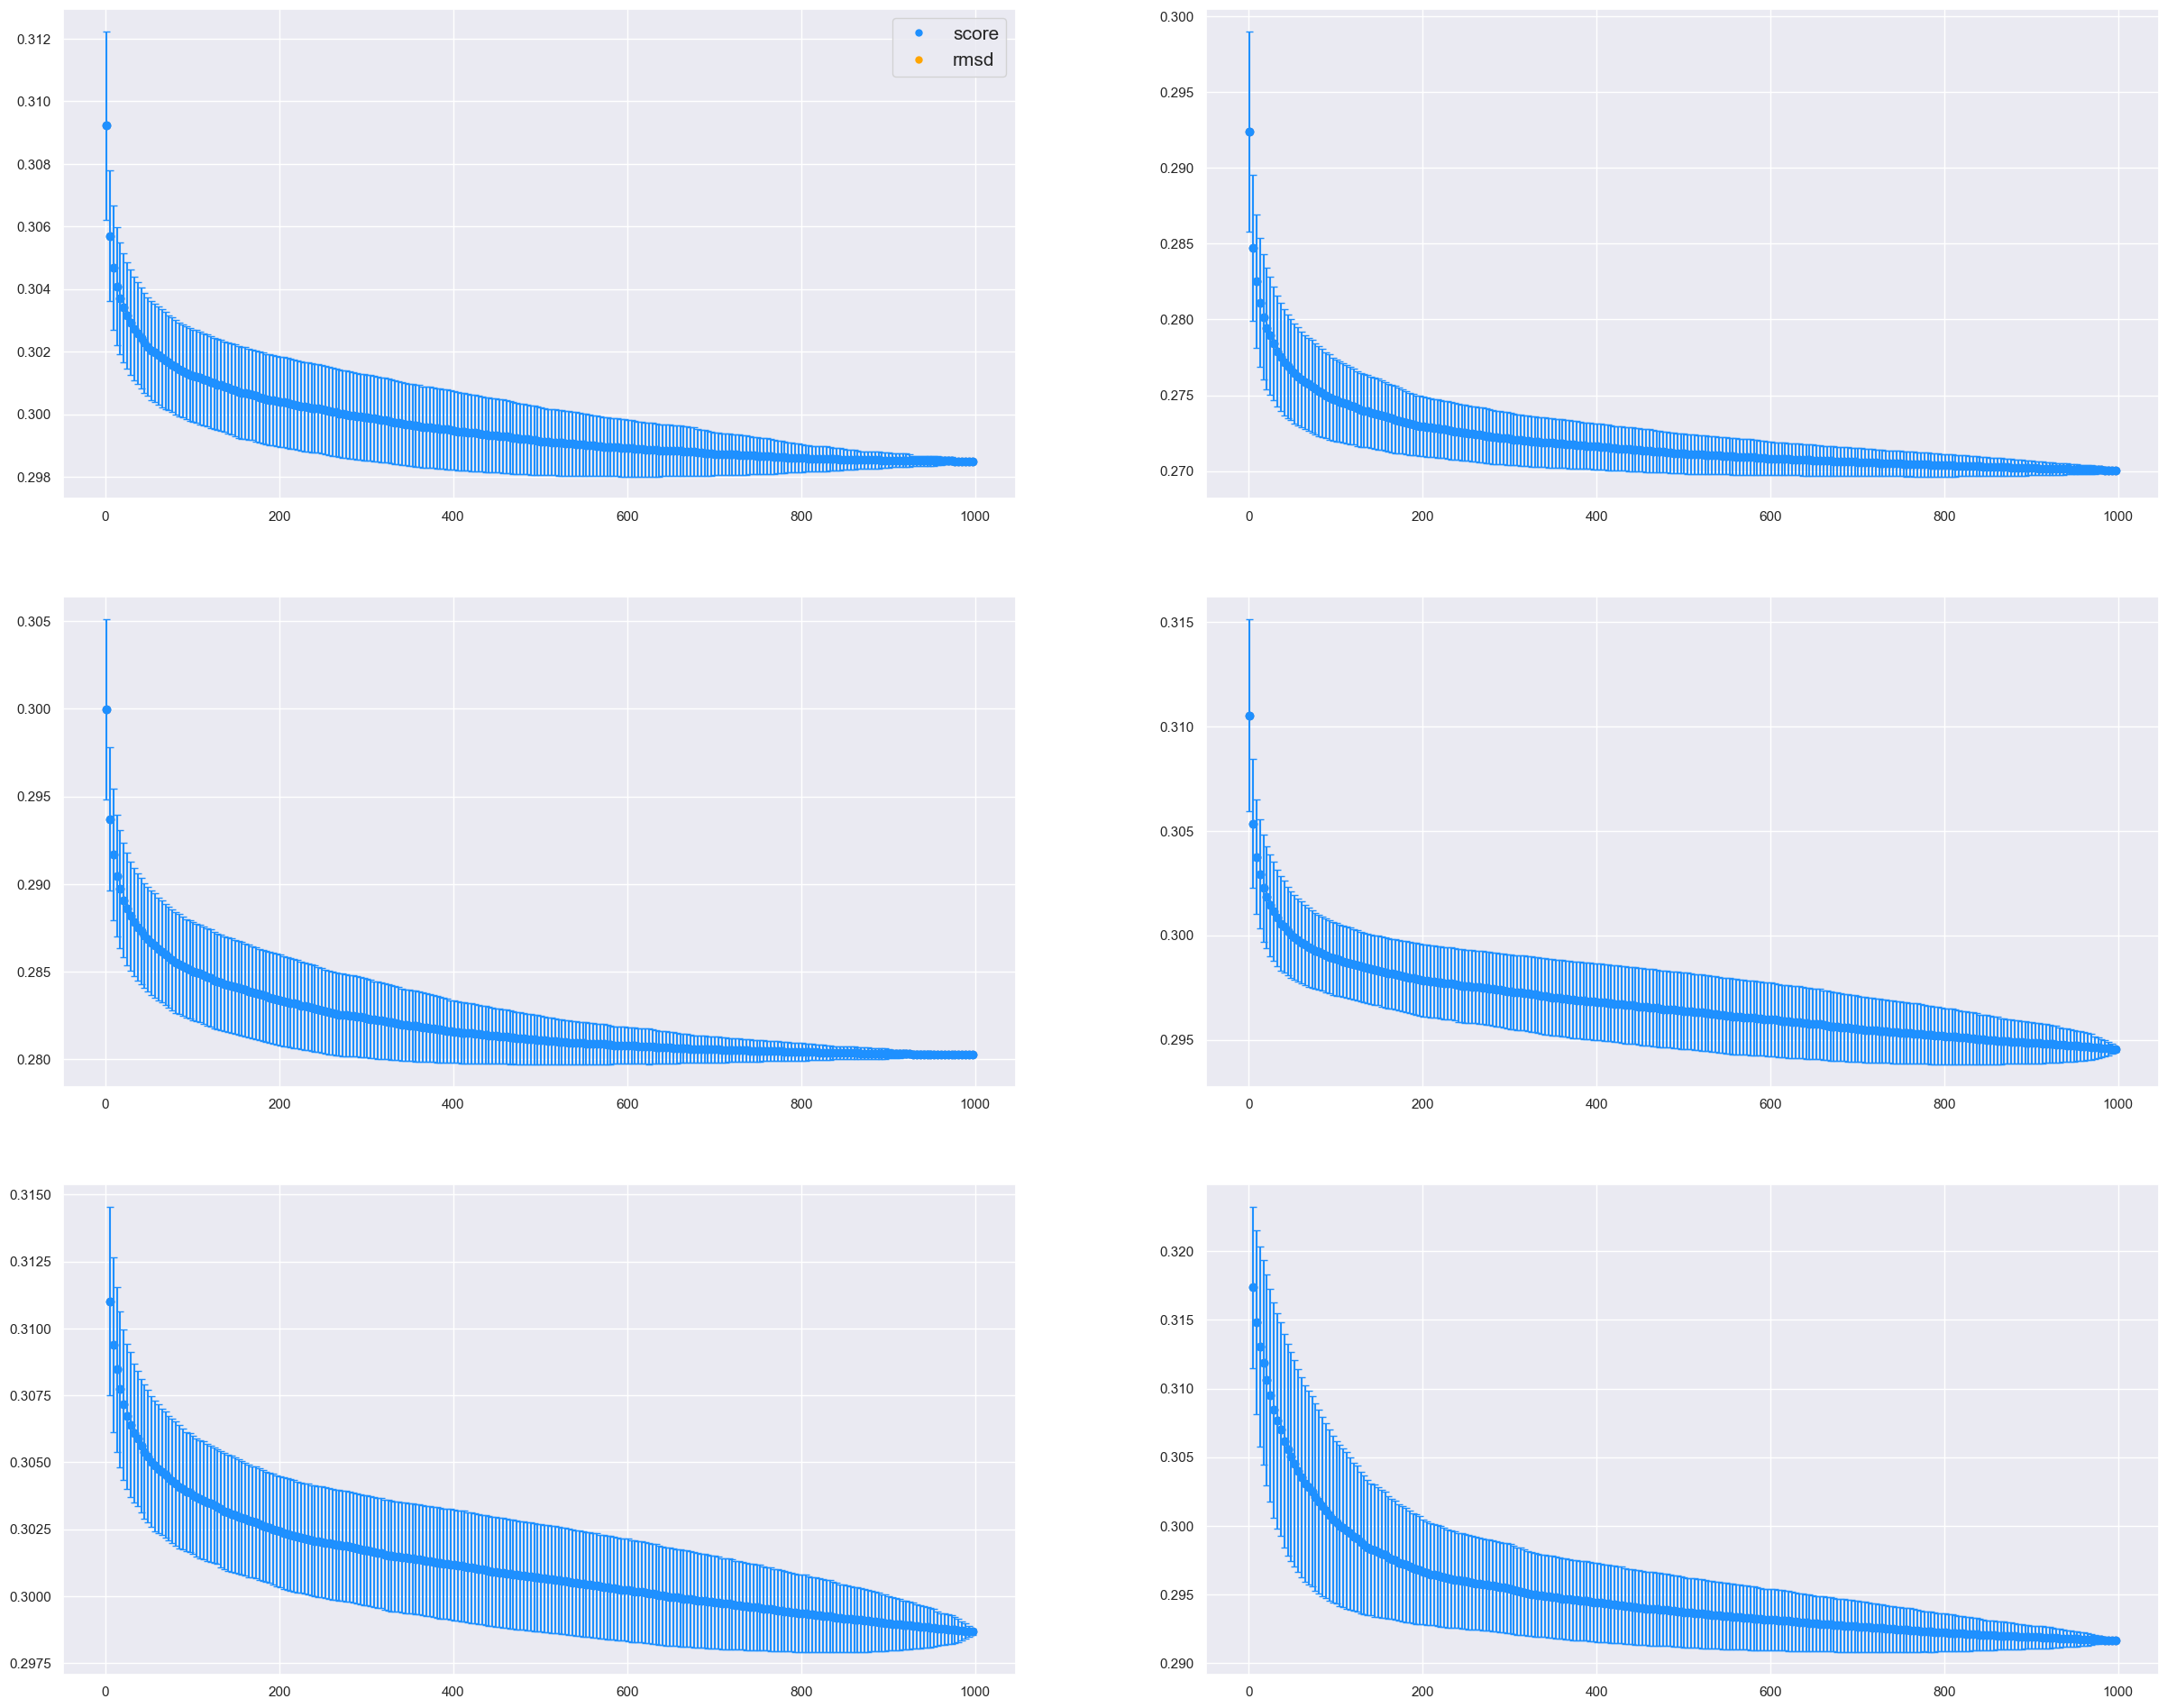

In [4]:
fig, axs = plt.subplots(n_row, 2, figsize=(30,8*n_row))

colors = list() 
colors.append(mcolors.CSS4_COLORS["dodgerblue"])
colors.append(mcolors.CSS4_COLORS["orange"])
colors.append(mcolors.CSS4_COLORS["orangered"])

alpha = .5
space = 4

custom_legend = list() 
custom_legend.append(Line2D([], [], marker='.', markersize=10, color=colors[0], linestyle='None'))
custom_legend.append(Line2D([], [], marker='.', markersize=10, color=colors[1], linestyle='None'))


for i in range(len(log_stats_dfs)):
    log_stats_df = log_stats_dfs[i]
    # x = log_stats_df["n"][::space]
    x = log_stats_df.index[::space]
    
    y1 = log_stats_df["r_free_mean"][::space]
    std1 = log_stats_df["r_free_std"][::space]
    
    # y2 = log_stats_df["rmsd_min_mean"][::space]
    # std2 = log_stats_df["rmsd_min_std"][::space]
    
    log_stats_df = log_stats_dfs[i]
    ax1 = axs[i//2][i%2]
    ax1.scatter(x, y1)
    ax1.errorbar(x, y1, std1, linestyle='None', marker='o', capsize=3, c=colors[0])
    if i == 0: 
        ax1.legend(custom_legend, ['score', 'rmsd'], loc="upper right", fontsize=15)
        
    # ax2 = ax1.twinx()
    # ax2.errorbar(x, y2, std2, linestyle='None', marker='o', capsize=3, c=colors[1], alpha=alpha)

#     ax1.plot(x, [start_scores[i]]*len(y1), c=colors[2])
#     ax2.plot(x, [start_rmsds[i]]*len(y1), c=colors[2])
    # ax1.plot(x, [native_scores[i]]*len(y1), c=colors[2])
    # ax1.plot(x, [5.345995252436289*30000]*len(y1), c=colors[2])

plt.savefig(Path(Path.home(), "Desktop/sample_bench.png"))

